In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

### Load HRF from `xBF.mat`

In [8]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)

#### 1. hrf

In [9]:
subj = 'S01'

In [10]:
reginfo = ssingle.load_reginfo(subj, glm)
reginfo

,sn,run,name,ons,beta
0,1,1,"(2,S)",6.03,beta_0001.nii
1,1,1,"(4,S)",11.03,beta_0002.nii
2,1,1,"(4,L)",16.03,beta_0003.nii
3,1,1,"(2,L)",21.03,beta_0004.nii
4,1,1,"(1,S)",26.03,beta_0005.nii
...,...,...,...,...,...
539,1,8,"(3,S)",3215.03,beta_0540.nii
540,1,8,"(3,L)",3220.03,beta_0541.nii
541,1,8,"(2,S)",3225.03,beta_0542.nii
542,1,8,"(2,L)",3230.03,beta_0543.nii


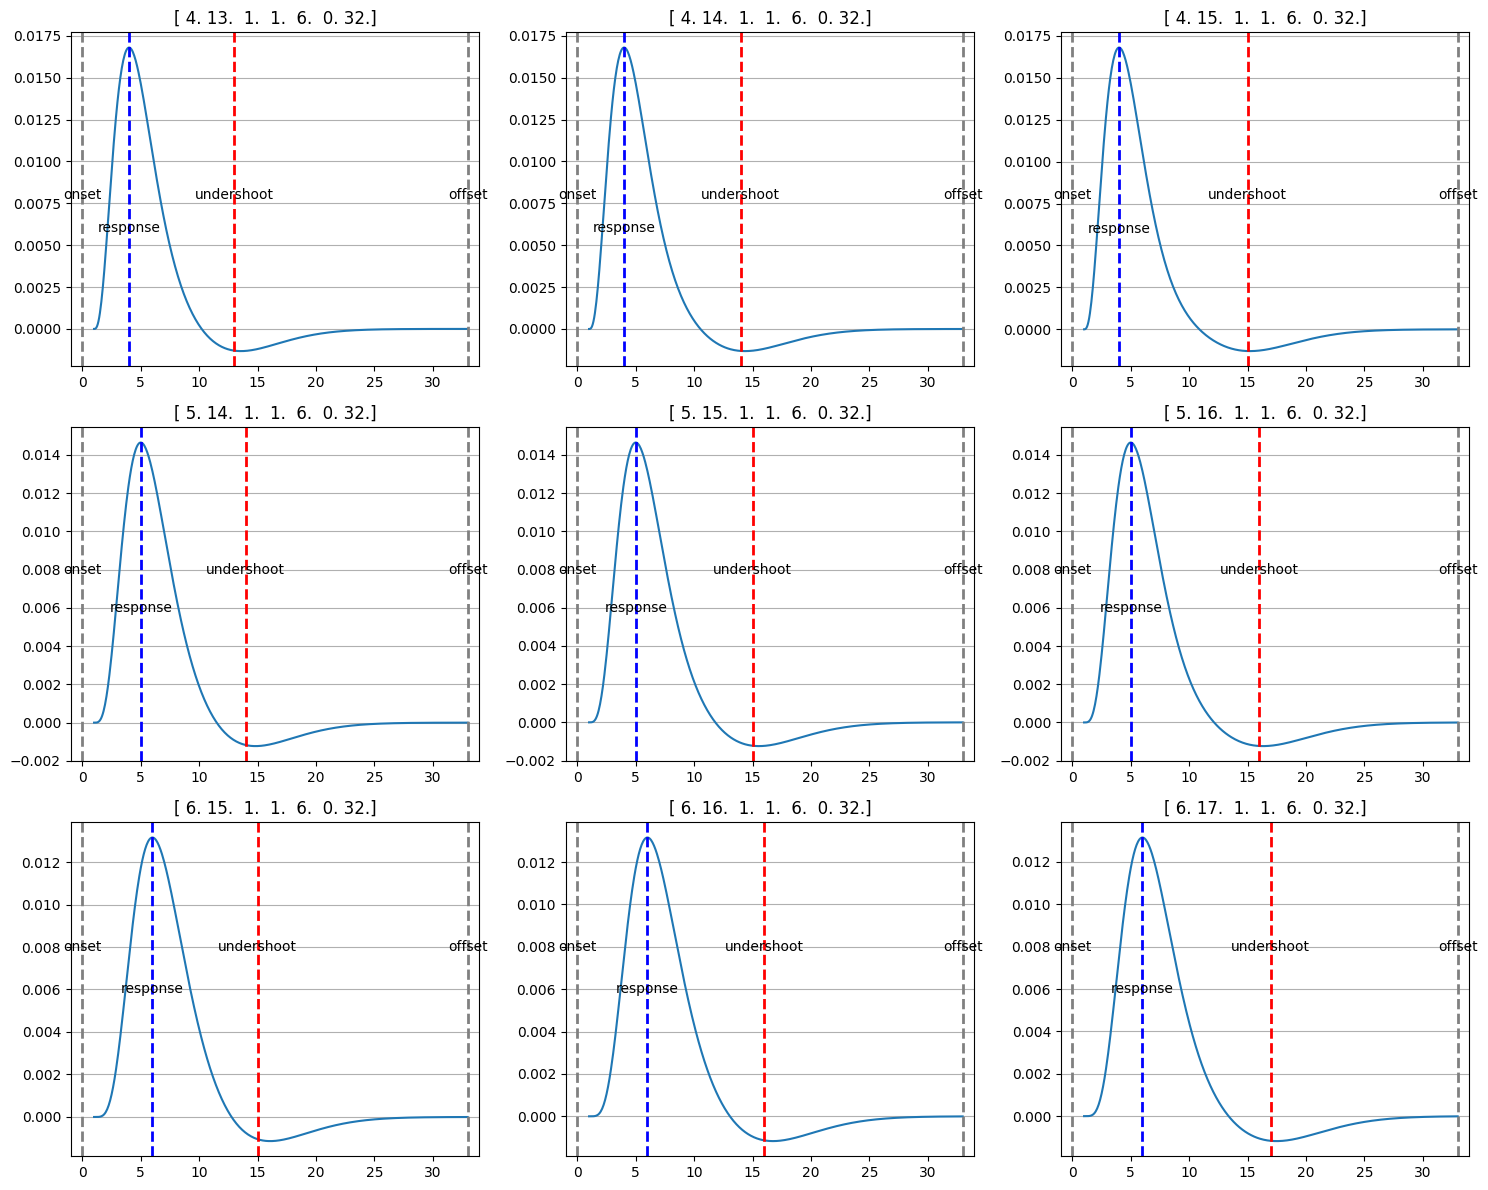

In [11]:
nrows, ncols = 3, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))
axs = np.concatenate(axs)

for ii, param in enumerate(list_param):
    ax = axs[ii]
    fname = join(dir_glm,subj,'hrf_tune/xBF_%s.mat'%su.convert_param_to_hrf(param, type='str'))
    xBF = deal_spm.get_xBF_params(fname)
    splt.plot_BF(xBF, ax=ax)
fig.tight_layout()

#### 2. overall response of $X$ by run

In [12]:
subj = 'S01'

In [13]:
SPM = join(dir_glm, subj,'SPM.mat')

df = deal_spm.get_df_X(SPM)
df

,TR,run,X_sum
0,0,1,0.000000
1,1,1,0.000000
2,2,1,0.000000
3,3,1,0.000000
4,4,1,0.000000
...,...,...,...
3251,402,8,-0.058913
3252,403,8,-0.050791
3253,404,8,-0.041897
3254,405,8,-0.033227


In [14]:
deal_spm.get_df_X(SPM)

,TR,run,X_sum
0,0,1,0.000000
1,1,1,0.000000
2,2,1,0.000000
3,3,1,0.000000
4,4,1,0.000000
...,...,...,...
3251,402,8,-0.058913
3252,403,8,-0.050791
3253,404,8,-0.041897
3254,405,8,-0.033227


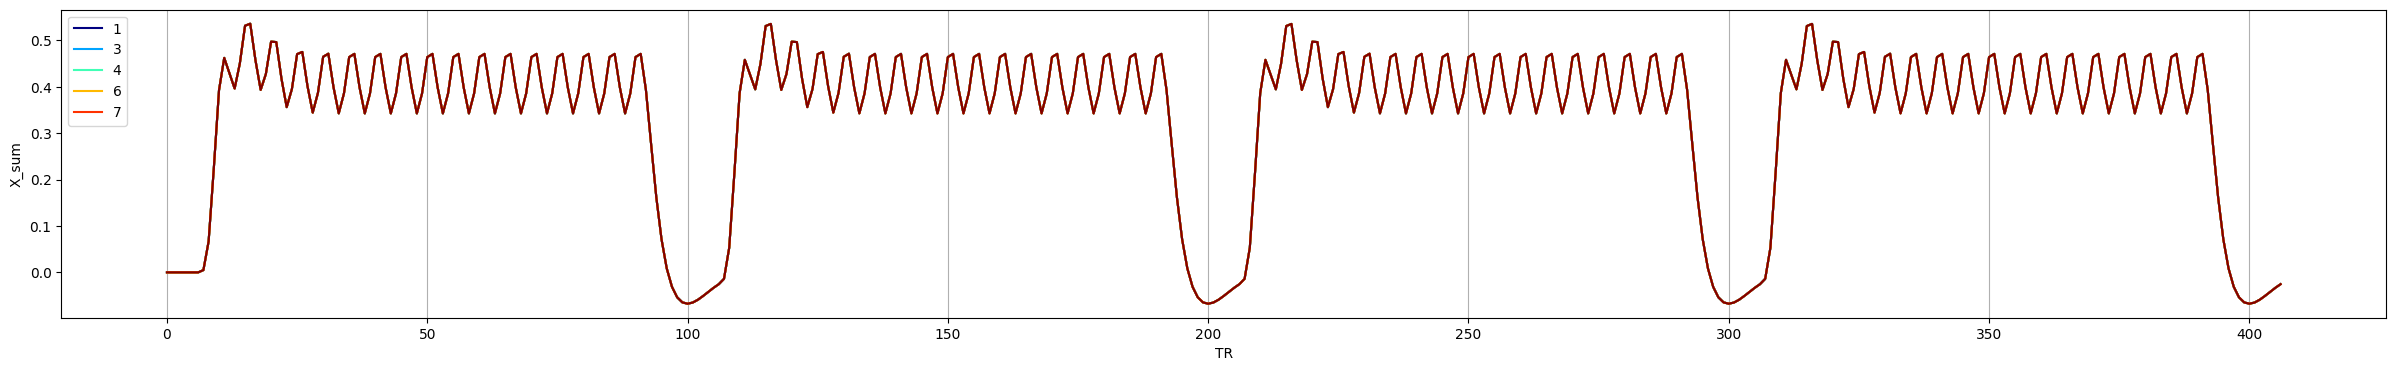

In [15]:
fig, ax = plt.subplots(figsize=(30,4))

g = sns.lineplot(
    data=df,
    x='TR', y='X_sum', hue='run',
    palette=cm.jet.resampled(8),
    ax=ax
)
g.grid(axis='x')
g.legend(loc='upper left')

In [16]:
del SPM, df

#### 3. overall response of $y$ by run

In [9]:
glm = 2
dir_glm = su.get_dir_glm(glm)

In [10]:
list_nn = su.get_list_sn()
list_subj = []
for sess in ['S','R']:
    for nn in list_nn:
        list_subj.append(sess+nn)
list_subj

['S01',
 'S02',
 'S03',
 'S05',
 'S06',
 'S08',
 'S09',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14',
 'R01',
 'R02',
 'R03',
 'R05',
 'R06',
 'R08',
 'R09',
 'R10',
 'R11',
 'R12',
 'R13',
 'R14']

In [13]:
list_roi = simage.get_list_roi()

In [14]:
dir_result = su.get_dir_result()
dir_work = join(dir_result,'GLM_%d.mean_y_across_run'%glm)
makedirs(dir_work, exist_ok=True)

In [15]:
nrows, ncols = len(list_roi), 1

for subj in tqdm(list_subj):
    SPM = join(dir_glm,subj,'SPM.mat')
    df_onset = deal_spm.get_df_onset(SPM)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30*ncols,4*nrows))
    for ii, roi in enumerate(list_roi):
        ax = axs[ii]
        plt.close()
        param = simage.get_optimal_hrf(
            subj=subj, roi=roi,
            r2_score=join(dir_glm,'r2_score.tsv')
        )
        df_y = simage.get_df_y(
            subj=subj, glm=glm, roi=roi, 
            param=param, 
            hemi='L',
            show_yraw=False, melt=True
        )
        g = sns.lineplot(
            data=df_y[df_y.hue!='y_res'],
            x='TR', y='y', hue='hue',
            errorbar='se',
            ax=ax
        )
        handles, labels = g.get_legend_handles_labels()
        g.legend(
            handles,
            [r'$%s_{%s}$'%(s.split('_')[0],s.split('_')[1]) for s in labels],
            loc='upper left', fontsize=12
        )
        g.grid(axis='x', linestyle='--', color='gray')
        g.set_ylabel(r'mean $y$ across run', fontsize=16)
        g.set_xlabel('TR', fontsize=16)
        xticks = g.get_xticks()[1:-1]
        g.set_xticks(xticks)
        g.set_xticklabels(['%d'%x for x in xticks], fontsize=14)
        yticks = g.get_yticks()[1:-1]
        g.set_yticks(yticks)
        g.set_yticklabels(['%.2f'%y for y in yticks], fontsize=14)
        g.set_title('%s %s'%(roi, su.convert_param_to_hrf(params=param,type='str')))

        onsets_by_run = []
        for rr in range(8):
            run = rr+1
            onsets_by_run.append(
                np.sort(
                    np.concatenate(df_onset[df_onset.run==run].onset.values)
                ).astype(int)
            )
        for onset in onsets_by_run[ii]:
            g.axvline(x=onset, color='red', linestyle='--')

    fig.tight_layout()
    fig.savefig(
        join(dir_work,'y_mean.%s.png'%(subj)),
        dpi=300, facecolor=[1,1,1,1],
        bbox_inches='tight'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 24/24 [13:33<00:00, 33.91s/it]


In [ ]:
# nrows, ncols = 6, 1

# # for ss in ['S','R']:
# for ss in ['S']:
#     # for nn in su.get_list_sn():
#     for nn in ['01']:
#         subj = ss+nn
#         SPM = join(dir_glm,subj,'SPM.mat')
#         df_onset = deal_spm.get_df_onset(SPM)
#         onsets_by_run = []
#         for rr in range(8):
#             run = rr+1
#             onsets_by_run.append(
#                 np.sort(
#                     np.concatenate(df_onset[df_onset.run==run].onset.values)
#                 ).astype(int)
#             )
#         # for roi in simage.get_list_roi():
#         for roi in ['SPLa']:
#             fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30*ncols,4*nrows))
#             plt.close()
#             # for ii, param in enumerate([[4,14],[5,15],[6,16],[7,17],[8,18],[9,19]]):
#             for ii, param in enumerate(list_param):
#                 ax = axs[ii]
#                 df_y = simage.get_df_y(subj=subj,glm=glm,roi=roi,param=param,hemi='L',show_yraw=False,melt=True)
#                 g = sns.lineplot(
#                     data=df_y[df_y.hue!='y_res'],
#                     x='TR', y='y', hue='hue',
#                     errorbar='se',
#                     ax=ax
#                 )
#                 handles, labels = g.get_legend_handles_labels()
#                 g.legend(handles, [r'$%s_{%s}$'%(s.split('_')[0],s.split('_')[1]) for s in labels], loc='upper left', fontsize=12)
#                 g.grid(axis='x', linestyle='--', color='gray')
#                 g.set_ylabel(r'mean $y$ across run', fontsize=16)
#                 g.set_xlabel('TR', fontsize=16)
#                 xticks = g.get_xticks()[1:-1]
#                 g.set_xticks(xticks)
#                 g.set_xticklabels(['%d'%x for x in xticks], fontsize=14)
#                 yticks = g.get_yticks()[1:-1]
#                 g.set_yticks(yticks)
#                 g.set_yticklabels(['%.2f'%y for y in yticks], fontsize=14)
#                 g.set_title('%s (%s, %s)'%(su.convert_param_to_hrf(params=param,type='str'), subj, roi))

#                 for onset in onsets_by_run[ii]:
#                     g.axvline(x=onset, color='red', linestyle='--')

#             fig.tight_layout()
#             plt.show()
#             # fig.savefig(
#             #     join(dir_work,'y_mean.%s.%s.png'%(subj,roi)),
#             #     dpi=300, facecolor=[1,1,1,1],
#             #     bbox_inches='tight'
#             # )

#### 4. Time series time lock to stimulus onset

In [16]:
glm = 2
dir_glm = su.get_dir_glm(glm)

In [17]:
list_roi = simage.get_list_roi()

In [18]:
dir_result = su.get_dir_result()
dir_work = join(dir_result,'GLM_%d.y_window'%glm)
makedirs(dir_work, exist_ok=True)

i) normal trials

In [19]:
nrows, ncols = 4, 2

for subj in tqdm(list_subj):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,4*nrows))
    axs = np.concatenate(axs)
    plt.close()
    for ii, roi in enumerate(list_roi):
        ax = axs[ii]
        param = simage.get_optimal_hrf(
            subj=subj, roi=roi,
            r2_score=join(dir_glm,'r2_score.tsv')
        )
        df_window_y = simage.get_df_window_y(subj=subj,glm=glm,roi=roi,param=param)

        g = sns.lineplot(
            data=df_window_y,
            x='TR', y='y', hue='hue',
            errorbar='se',
            ax=ax
        )
        handles, labels = g.get_legend_handles_labels()
        g.legend(
            handles,
            [r'$%s_{%s}$'%(s.split('_')[0],s.split('_')[1]) for s in labels],
            loc='upper left', fontsize=12
        )
        g.grid(axis='x', linestyle='--', color='gray')
        g.set_ylabel(r'mean $y$ across window', fontsize=16)
        g.set_xlabel('TR', fontsize=16)
        xticks = g.get_xticks()[1:-1]
        g.set_xticks(xticks)
        g.set_xticklabels(['%d'%x for x in xticks], fontsize=14)
        yticks = g.get_yticks()[1:-1]
        g.set_yticks(yticks)
        g.set_yticklabels(['%.2f'%y for y in yticks], fontsize=14)
        g.set_title('%s %s'%(roi, su.convert_param_to_hrf(params=param,type='str')))
        g.axvline(x=0, color='red', linestyle='-')

    fig.suptitle(subj, fontsize=16)
    fig.tight_layout()
    fig.savefig(
        join(dir_work,'y_window.%s.png'%subj),
        dpi=300, facecolor=[1,1,1,1],
        bbox_inches='tight'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 24/24 [04:23<00:00, 10.96s/it]


In [ ]:
# nrows, ncols = 4, 2

# for ss in ['S','R']:
#     for nn in su.get_list_sn():
#         subj = ss+nn
#         for roi in simage.get_list_roi():
#             for param in [[4,14],[5,15],[6,16],[7,17],[8,18],[9,19]]:
#                 df_window_y = simage.get_df_window_y(subj=subj,glm=glm,roi=roi,param=param)

#                 fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,4*nrows))
#                 axs = np.concatenate(axs)
#                 plt.close()
#                 for rr in range(8):
#                     ax = axs[rr]
#                     run = rr+1
#                     g = sns.lineplot(
#                         data=df_window_y[df_window_y.run==run],
#                         x='TR', y='y', hue='hue',
#                         ax=ax
#                     )
#                     handles, labels = g.get_legend_handles_labels()
#                     g.legend(handles, [r'$%s_{%s}$'%(s.split('_')[0],s.split('_')[1]) for s in labels], loc='upper left', fontsize=12)
#                     g.grid(axis='x', linestyle='--', color='gray')
#                     g.set_ylabel(r'mean $y$ across window', fontsize=16)
#                     g.set_xlabel('TR', fontsize=16)
#                     xticks = g.get_xticks()[1:-1]
#                     g.set_xticks(xticks)
#                     g.set_xticklabels(['%d'%x for x in xticks], fontsize=14)
#                     yticks = g.get_yticks()[1:-1]
#                     g.set_yticks(yticks)
#                     g.set_yticklabels(['%.2f'%y for y in yticks], fontsize=14)
#                     g.set_title('run%02d (%s, %s, %s)'%(run, subj, roi, str(param)))
#                     g.axvline(x=0, color='red', linestyle='-')

#                 fig.tight_layout()
#                 # plt.show()
#                 fig.savefig(
#                     join(dir_work,'y_window.%s.%s.%s.png'%(subj,roi,su.convert_param_to_hrf(params=param,type='str'))),
#                     dpi=300, facecolor=[1,1,1,1],
#                     bbox_inches='tight'
#                 )

ii) gap trials

In [20]:
pre, post = 5, 25

In [21]:
nrows, ncols = 4, 2
for subj in tqdm(list_subj):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
    axs = np.concatenate(axs)
    plt.close()
    for ii, roi in enumerate(list_roi):
        ax = axs[ii]
        param = simage.get_optimal_hrf(
            subj=subj, roi=roi,
            r2_score=join(dir_glm,'r2_score.tsv')
        )
        df_window_y = simage.get_df_window_y(
            subj=subj,
            glm=glm,
            roi=roi,
            param=param,
            pre=pre,post=post,
            gap=16
        )
        g = sns.lineplot(
            data=df_window_y,
            x='TR', y='y', hue='hue',
            errorbar='se',
            ax=ax
        )
        g.grid(axis='x',linestyle='-')
        g.legend()
        xticks = np.arange(-pre,post+.1,5).astype(int)
        g.set_xticks(xticks)
        g.set_xticklabels(['%d'%x for x in xticks], fontsize=10)
        g.set_xlabel(g.get_xlabel(), fontsize=12)
        g.set_ylabel(r'mean $Y$ across run', fontsize=12)
        g.set_title(su.convert_param_to_hrf(param), fontsize=12)
        g.set_title('%s %s'%(roi, su.convert_param_to_hrf(param)), fontsize=12)
        
        for t in [-5,0,20,25]:
            g.axvline(x=t, color='r', linestyle='--')

    fig.suptitle(subj, fontsize=16)
    fig.tight_layout()
    fig.savefig(
        join(dir_work,'y_window.%s.gap_trial.png'%subj),
        dpi=300, facecolor=[1,1,1,1],
        bbox_inches='tight'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 24/24 [02:07<00:00,  5.31s/it]


---

## Load $\beta$

In [ ]:
subj = 'R01'
glm = 3
param = [6,16]
roi = 'M1'

In [ ]:
beta = simage.load_hrf_tune(subj=subj,glm=glm,roi=roi,param=param,map_='beta')
beta

In [ ]:
dir_glm = su.get_dir_glm(glm)
SPM = join(dir_glm,subj,'SPM.mat')
deal_spm.get_df_vec(SPM)

In [ ]:
fig, ax = plt.subplots()

## (# interest, # voxels)
print(beta.shape)
sns.heatmap(beta.get_fdata(),ax=ax)
plt.show()

---

In [ ]:
# %whos